# DQN on the CartPole problem

In this assignment you will implement the DQN algorithm to solve a classic control problem, the CartPole.

### The CartPole problem

As the image below shows, the goal of the agent is to balance a verticle rod on the top of the car. This position is unstable and that is the main reason for the difficulty.

<img src="https://drive.google.com/uc?export=download&id=1wiFksyB3-mcirfdZEvrT2DPD7SBEjye2" >
<img src="RL-final.png" >

The problem is solved if the average of the agent's scores is greater than 195 gathered in 100 episodes.
The agent receives reward 1 in each timestep as long as the position of the rod is correct (not inclined too far away from the vertical position).
The length of one episode is 200 time steps. Therefore the possible maximum score is 200.

The state is low dimensional and cosists of:
* position
* velocity
* angle
* angular velocity

Further details can be found on OpenAI gym's webpage: (https://gymnasium.farama.org/environments/classic_control/cart_pole/)

In [11]:
# Installs necessary in Colab
#!pip install gymnasium
#!pip install gymnasium[classic-control]

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import random
from enum import Enum
from skimage import transform as trf
from keras.models import Sequential # Keras: highlevel API above dnn libraries (tendorflow, cntr, theano)
from keras.layers import Dense, Convolution2D, Flatten
#from keras.optimizers import Adam, SGD, RMSprop
#Locally I need legacy due to m1 mac
from keras.optimizers.legacy import Adam, SGD, RMSprop 
from numpy.random import seed

In [13]:
class Optimizer(Enum): # Enum, Makes easier to try different optimizers
    ADAM = 1
    RMSPROP = 2
    SGD = 3

In [14]:
# The implementation of DQN.
class Dqn:

    def __init__(self, params):
        self.env = None                       # The environment where the RL agent will learn.
        self.buffer_size = params.buf_size    # The maximum size of the experience replay.
        self.batch_size = params.batch        # Batch size during training.
        self.epoch = params.epoch             # For one training cycle, the number epoch on a batch.
        self.max_episode = params.max_ep      # The number of episodes for training.
        self.eps0 = params.eps                # The starting value of epsilon in the epsilon-greedy policy.
        self.gamma = params.gamma             # Discounting factor.
        self.C = params.C                     # Frequency of synchronizing the frozen network.
        self.train_freq = params.train_freq   # Update frequency for the not frozen network.
        self.eval_freq = params.eval_freq     # Evaluation frequency.
        self.net = params.net                 # The description of the network. List of tuples. A tuple: (number of units, activation)
        self.lr = params.lr                   # learning rate
        self.opt = params.opt                 # Optimizer.

        self.q_cont, self.q_frzn = None, None # two networks for training: continuously updated and frozen

        self.buffer = []  # experience replay

        # Changed to v1, v0 gives a warning and recommends upgrading
        self.env = gym.make('CartPole-v1', render_mode="rgb_array" )

        self.env.reset(seed=1, options={})
        self.q_cont, self.q_frzn = self._init_models()

    # ------------------------------------------------------
    # functions for initialization

    def _init_optimizer(self):

        optz = None
        if self.opt == Optimizer.ADAM:
            optz = Adam(self.lr)
        elif self.opt == Optimizer.SGD:
            optz = SGD(self.lr)
        elif self.opt == Optimizer.RMSPROP:
            optz = RMSprop(self.lr)

        return optz

    # The network builds up from Dense layers (similar to the fully connected)
    def _init_models(self):

        def build(strc):
            # strc - list of tuples
            # each tuple contains: number of nodes in the dense layer, activation function name (e.g.: 'relu')
            # ----- implement this -----
            q = Sequential()  # ----- create a sequential model -----
            # ----- add a dense layer with input_shape 4 (4 frames will be stacked) -----
            # use the strc for accessing the required parameters
            q.add(Dense(strc[0][0], activation=strc[0][1], input_shape=(4,)))

            for i in range(1, len(strc)):
                # ----- add the remaining dense layers to the model
                q.add(Dense(strc[i][0], activation=strc[i][1]))


            optz = self._init_optimizer()
            # compile the model with an appropriate loss function
            q.compile(optimizer=optz, loss='mse')

            return q

        q_cont = build(self.net)  # continuously updated network (Q-function)
        q_frzn = build(self.net)  # frozen network

        q_cont.set_weights(q_frzn.get_weights())  # synchronization
        return q_cont, q_frzn

    def _init_buffer(self, number):
        # gathers 'number' pieces of experiences randomly
        # ----- study and understand this piece of code carefully -----
        exps = []
        obs, rw, terminated, truncated , _ = self.env.step(0)
        done = terminated or truncated

        for _ in range(number):

            if done:
                obs, info = self.env.reset(seed=1, options={})

            action = self.env.action_space.sample()  # sampling random actions from the environment
            obs_next, rw, terminated, truncated , _= self.env.step(action)  # taking the step and observe the results
            done = terminated or truncated
            exps.append((obs, rw, action, done, obs_next))  # we append a new experience
            obs = obs_next

        self.append(exps)  # you will implement this function

    def close(self):
        self.env.close()

    def train_function(self):

        # initializing experience replay with random experiences
        self._init_buffer(self.batch_size)

        print("Initialization was finished.")
        print("Training was started.")

        ep_id = 1
        cntr = 0
        eval_permitted = True
        rtn = 0
        exps = []

        ep_ids = []
        returns = []

        eps = self.eps0
        self.env.reset()
        obs, _, terminated, truncated , _ = self.env.step(0)
        done = terminated or truncated


        while ep_id < self.max_episode:

            cntr += 1

            if done:
                if ep_id % 10 == 0:
                    print('Episode Id: ' + str(ep_id) + ' Return during training: ' + str(rtn))
                rtn = 0
                ep_id += 1
                eval_permitted = True
                obs, info = self.env.reset(seed=1, options={}) # when an episode ends (done = True) the environment is reseted
            
            # ---- select the next action with epsilon greedy -----
            action = self.select_action_epsilon(obs, eps)

            # ----- take a new step with the environment -----
            obs_next, rw, terminated, truncated , _ = self.env.step(action)
            done = terminated or truncated

            rtn += rw

            if done:
                if rtn < 180:
                    rw = -1
                    obs_next *= 0.0
                    obs *= 0.0
                elif rtn >= 180:
                    rw = 100

            exps.append((obs, rw, action, done, obs_next))
            obs = obs_next

            if cntr % 128 == 0:
                self.append(exps)
                exps.clear()

            # training
            if  cntr % self.train_freq == 0:
                # ----- sample experiences from the replay then train q_cont with them
                x, y = self.sample(self.batch_size)
                self.q_cont.train_on_batch(x, y)


            # synchronizing the frozen network
            if cntr % self.C == 0:
                self.q_frzn.set_weights(self.q_cont.get_weights())

            # evaluating at the current stage of learning
            if ep_id % self.eval_freq == 0 and eval_permitted:
                r = self.evaluation()
                ep_ids.append(ep_id)
                returns.append(r)
                print('EValuation at episode: ' + str(ep_id) + ' -> ' +  str(r))
                eval_permitted = False
                if r >= 185:
                    break

            # Decrasing the epsilon value for epsilon-greedy. Exploration -> exploitation
            eps = max(eps - 0.001, 0.01)

        print("Training was finished.")
        return ep_ids, returns

    def evaluation(self, video=False):
        orig_env = self.env

        obs, info = self.env.reset(seed=1, options={})
        done = False
        rtn = 0
        ep_id = 0
        rtns = []

        while ep_id < 50:

            if done:
                rtns.append(rtn)
                rtn = 0
                ep_id += 1
                obs, info  = self.env.reset(seed=1, options={})


            action = self.select_action_epsilon(obs, 0.01)
            obs, rw, terminated, truncated , _ = self.env.step(action)
            print("terminated" + str(terminated))
            print("truncated" + str(truncated))
            done = terminated or truncated

            rtn += rw

        self.env = orig_env
        return np.mean(rtns)

    # ------------------------------------------------------
    # Functions for handling the experience replay

    def clear_buffer(self):
        self.buffer.clear()

    # The new experiences are added at the end of the buffer.
    # The too old experiences are deleted.
    def append(self, experiences):
        # experiences - list of experiences
        # ----- implement this -----

        # ----- check if appending the new set of experiences to the buffer has enough space -----
        if len(self.buffer) + len(experiences) > self.buffer_size:
            # ----- if not, delete as many experiences as required -----
            excess = len(self.buffer) + len(experiences) - self.buffer_size
            self.buffer = self.buffer[excess:]

        self.buffer += experiences  # finally we append the new experiences to the buffer

    def sample(self, number):
        exps = random.sample(self.buffer, number)    # experiences list
        obs = np.stack([x[0] for x in exps], axis=0) # numpy array is used by keras, for creating a batch observations should be stacked
        rws = np.array([e[1] for e in exps]) # ----- do similar stacking for the rewards -----
        acts = np.array([e[2] for e in exps]) # ----- implement this too -----
        dones = np.array([e[3] for e in exps]) # ----- implement this too -----
        next_obs = np.stack([e[4] for e in exps]) # ----- implement this too -----

        q_vals = self.q_cont.predict(obs) # ----- predict (forward execute) with q_cont on obs -----   # q_vals size should be: (batch_size, 2)
        fzn_q_vals = self.q_frzn.predict(next_obs) # ----- predict with q_frzn on next_obs -----

        # The action function is represented by a network.
        # The input of this network is the state,
        # the output is the set of action-values
        # corresponding to the actions.
        # So the number of outputs is equal with the nunmber of actions.
        # In training we sample one transition at a time, therefore we have loss
        # for only one output (action) at a time.
        # But for training, we have to provide information for all of the outputs.
        # How can we solve this?

        ## The input to the neural network is the stack of observations (obs).
        ## The target should also be passed during the training. The target is nothing but the immediate reward + discounted value of the next state.
        ## We should get the next state’s value by using the frozen network and the max of the value shall be taken as per Q-learning algorithm.
        ## this is how the sub_values shall be calculated which is the target value during training.
        
        # ----- calculate this according to the one-step return for Q-learning -----
        sub_values = rws + self.gamma * np.max(fzn_q_vals, axis=1) * (1 - dones)
        q_vals[list(range(number)), acts] = sub_values  # this will be the target during training

        x = obs.astype(dtype=np.float32)
        y = q_vals.astype(dtype=np.float32)

        return x, y

    # ------------------------------------------------------
    # Choosing an action

    # epsilon-greedy
    def select_action_epsilon(self, state, eps):  # state shape: (4) nunmpy array
        s = np.expand_dims(state, axis=0)
        max_idx = np.argmax(self.q_cont.predict(s, batch_size=1, verbose=0))
        if np.random.random() < 1 - eps:
            return max_idx
        return (max_idx + 1) % 2 # now we have only two actions

    # no epsilon-greedy
    def select_action(self, state):
        s = np.expand_dims(state, axis=0)
        return np.argmax(self.q_cont.predict(s, batch_size=1, verbose=0))

In [15]:
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 100        # 100
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Initialization was finished.
Training was started.
8/8 [==============================] - 0s 540us/step
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedTrue
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedTrue
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse

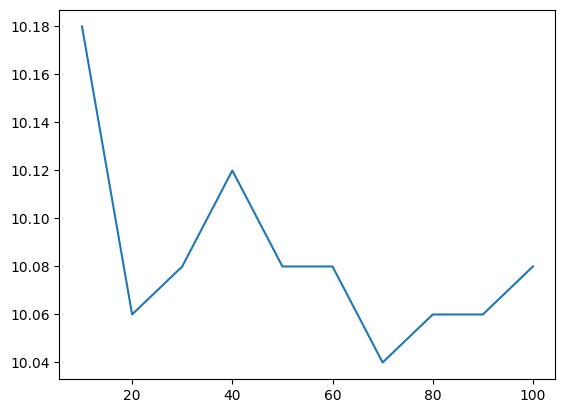

In [16]:
# Running the training and evaluation
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

### Question:

* Does the algorithm converge all the time?
* What happens if you change the default parameters?
* How does your algorithm compare to other algorithms on the leader board?
* Search the literature: What type of other algorithms are used to solve this problem (e.g. actor-critic)? (Preset policies do not matter.)
* Remove the activation functions from your network. This results in a linear approximator. How do the results change?

## Question 1


In [17]:
dqn.evaluation(video=False)

terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedTrue
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedTrue
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedTrue
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedF

10.16

In [18]:
dqn.evaluation(video=False)

terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedTrue
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedTrue
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedTrue
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedF

10.02

In [19]:
dqn.evaluation(video=False)

terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedTrue
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedTrue
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedTrue
truncatedFalse
terminatedFalse
truncatedFalse
terminatedF

10.14

In [20]:
dqn.evaluation(video=False)

terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedTrue
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedTrue
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedTrue
truncatedFalse
terminatedFalse
truncatedFalse
terminatedFalse
truncatedFalse
terminatedF

10.1